# 欄位介紹
### InvoiceNo: 發票號碼. 唯一值, "C"開頭代表該交易取消
### ItemCode: 產品代碼, 每個產品的唯一值
### DescriptionCode: 商品敘述代碼
### Quantity: 每個商品數量
### SellDate: 發票產生時間, 代表每筆交易發生的日期跟時間
### NewTaiwanDollors: 物品單價
### CustomerID: 用戶代碼, 唯一值
### District: 銷售縣市

# EDA

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sqlite3
import pandas as pd
import numpy as np
import time
import math
import datetime as dt
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('ecommerce.db')
c = conn.cursor()

retail = pd.read_sql('''SELECT * FROM ecommerce''', conn)

# 顯示基本訊值
retail.head()

InvoiceNo ItemCode DescriptionCode  Quantity        SellDate  \
0    536365   85123A         1546686         6  12/1/2018 8:26   
1    536365    71053         1466048         6  12/1/2018 8:26   
2    536365   84406B         4510747         8  12/1/2018 8:26   
3    536365   84029G         6497318         6  12/1/2018 8:26   
4    536365   84029E         3876120         6  12/1/2018 8:26   

   NewTaiwanDollors  CustomerID             District  
0             255.0     17850.0  Zhongzheng District  
1             339.0     17850.0  Zhongzheng District  
2             275.0     17850.0  Zhongzheng District  
3             339.0     17850.0  Zhongzheng District  
4             339.0     17850.0  Zhongzheng District

In [2]:
# 做 EDA, 先看缺值值
retail.isna().sum().sort_values(ascending=False)

# 發現 CustomerID 占比最高
pd.DataFrame(data = (retail.isna().sum() / retail.shape[0]) * 100, index = retail.columns, columns = ['% Null Values'])

# 踢掉空值:
retail.dropna(subset=['CustomerID'],how='any',inplace=True)

# 再查看一次缺值
retail.isna().sum()

CustomerID          135080
DescriptionCode       1454
District                 0
NewTaiwanDollors         0
SellDate                 0
Quantity                 0
ItemCode                 0
InvoiceNo                0
dtype: int64

% Null Values
InvoiceNo              0.000000
ItemCode               0.000000
DescriptionCode        0.268311
Quantity               0.000000
SellDate               0.000000
NewTaiwanDollors       0.000000
CustomerID            24.926694
District               0.000000

InvoiceNo           0
ItemCode            0
DescriptionCode     0
Quantity            0
SellDate            0
NewTaiwanDollors    0
CustomerID          0
District            0
dtype: int64

In [3]:
# 查看重複
retail.duplicated().sum()
# 去重複
retail.drop_duplicates(inplace=True)       

5225

In [4]:
# Removing the cancelled orders 
retail = retail[retail['Quantity'] > 0]

In [5]:
# 確認交易次數, 購買數量, 客戶數
pd.DataFrame(data=[retail['InvoiceNo'].nunique(),retail['ItemCode'].nunique(),retail['CustomerID'].nunique()],columns=['Count'],
                   index=['Number of Transactions','Number of Unique Products Bought','Number of Unique Customers'])

Count
Number of Transactions            18536
Number of Unique Products Bought   3665
Number of Unique Customers         4339

# RFM Analysis ( Recency、Frequency、Monetary )

## Recency 最近一次消費

In [6]:
# 最近消費時間：
retail['InvoiceDate'] = retail['SellDate'].astype('datetime64')
retail['InvoiceDate'].max()
tsp = str(retail['InvoiceDate'].max()).split(' ')[0].split('-')
now = dt.date(int(tsp[0]),int(tsp[1]),int(tsp[2]))
print('Recent Consumption: ',now)

# 每個客戶近一次消費時間：
retail['Date'] = retail['InvoiceDate'].apply(lambda x: x.date())
recency_df = retail.groupby(by='CustomerID', as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()
recency_df['LastPurshaceDate'].max()

# 每個客戶距離最近一次消費時間
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
# recency_df.head()
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)
recency_df.head()

Timestamp('2018-12-23 16:06:00')

Recent Consumption:  2018-12-23


CustomerID LastPurshaceDate
0     12346.0       2011-01-18
1     12347.0       2018-12-07
2     12348.0       2018-12-16
3     12349.0       2011-11-21
4     12350.0       2011-02-02

datetime.date(2018, 12, 23)

CustomerID  Recency
0     12346.0     2896
1     12347.0       16
2     12348.0        7
3     12349.0     2589
4     12350.0     2881

## Frequency 消費頻率

In [7]:
temp = retail.copy()
temp.drop_duplicates(['InvoiceNo','CustomerID'],keep='first',inplace=True)
frequency_df = temp.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

CustomerID  Frequency
0     12346.0          1
1     12347.0          7
2     12348.0          4
3     12349.0          1
4     12350.0          1

## Monetary 消費金額 

In [8]:
retail['TotalCost'] = retail['Quantity'] * retail['NewTaiwanDollors']

# 每個顧客消費總金額
monetary_df = retail.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

CustomerID   Monetary
0     12346.0  7718360.0
1     12347.0   431000.0
2     12348.0   179724.0
3     12349.0   175755.0
4     12350.0    33440.0

## Create RFM Table

In [9]:
rfm_df = recency_df.merge(frequency_df,on='CustomerID').merge(monetary_df,on='CustomerID')
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

Recency  Frequency   Monetary
CustomerID                               
12346.0        2896          1  7718360.0
12347.0          16          7   431000.0
12348.0           7          4   179724.0
12349.0        2589          1   175755.0
12350.0        2881          1    33440.0

## Customer segments with RFM Model

In [10]:
### 假設 80-20 法則： 20% 顧客消費金額貢獻了80%的總金額

pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print('總體80%的金額：', pareto_cutoff)

# 先建立 Rank 欄位：
customers_ranked = rfm_df
customers_ranked['Rank'] = customers_ranked['Monetary'].rank(ascending=False)

# Rank 排序：
customers_ranked.sort_values(by='Rank',ascending=True,inplace=True)
customers_ranked.shape
# 取前20%
top_20_cutoff = customers_ranked.shape[0] * 20 /100
top_20_cutoff = math.ceil(top_20_cutoff)
revenueByTop20 = customers_ranked[customers_ranked['Rank'] <= 868]['Monetary'].sum()
print('前20%的人花費金額：', revenueByTop20)
print()
print('80-20 Rule Ratio:', revenueByTop20/pareto_cutoff)

總體80%的金額： 710976711.52


(4339, 4)

前20%的人花費金額： 663730082.1

80-20 Rule Ratio: 0.9335468677743449


### Applying RFM Score Formula

In [11]:
# 用 4 分位來做 RFM Quartiles
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles
quantiles.to_dict()

Recency  Frequency  Monetary    Rank
0.25   2575.0        1.0   30645.5  1085.5
0.50   2604.0        2.0   66856.0  2170.0
0.75   2675.0        5.0  166031.5  3254.5

{'Recency': {0.25: 2575.0, 0.5: 2604.0, 0.75: 2675.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 30645.5, 0.5: 66856.0, 0.75: 166031.5},
 'Rank': {0.25: 1085.5, 0.5: 2170.0, 0.75: 3254.5}}

In [12]:
# 依據 RFM 評分：
#  Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4


In [13]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [14]:
rfm_segmentation.head()

Recency  Frequency    Monetary  Rank  R_Quartile  F_Quartile  \
CustomerID                                                                 
14646.0           2         74  28020602.0   1.0           4           4   
18102.0          14         60  25965730.0   2.0           4           4   
17450.0          16         46  19439079.0   3.0           4           4   
16446.0        2571          2  16847250.0   4.0           4           2   
14911.0           0        201  14371117.0   5.0           4           4   

            M_Quartile  
CustomerID              
14646.0              4  
18102.0              4  
17450.0              4  
16446.0              4  
14911.0              4

In [15]:
# Best Recency score = 4: most recently purchased.
# Best Frequency score = 4: most quantity purchase.
# Best Monetary score = 4: spent the most.
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

Recency  Frequency    Monetary  Rank  R_Quartile  F_Quartile  \
CustomerID                                                                 
14646.0           2         74  28020602.0   1.0           4           4   
18102.0          14         60  25965730.0   2.0           4           4   
17450.0          16         46  19439079.0   3.0           4           4   
16446.0        2571          2  16847250.0   4.0           4           2   
14911.0           0        201  14371117.0   5.0           4           4   

            M_Quartile RFMScore  
CustomerID                       
14646.0              4      444  
18102.0              4      444  
17450.0              4      444  
16446.0              4      424  
14911.0              4      444

In [16]:
# 以消費總金額來做排序, 看哪些用戶拿到 444滿分：
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

Recency  Frequency    Monetary  Rank  R_Quartile  F_Quartile  \
CustomerID                                                                 
14646.0           2         74  28020602.0   1.0           4           4   
18102.0          14         60  25965730.0   2.0           4           4   
17450.0          16         46  19439079.0   3.0           4           4   
14911.0           0        201  14371117.0   5.0           4           4   
14156.0          20         55  11721008.0   7.0           4           4   
17511.0           8         31   9106238.0   8.0           4           4   
16029.0           2         63   8085084.0   9.0           4           4   
16684.0           3         28   6665356.0  11.0           4           4   
14096.0        2575         17   6516479.0  12.0           4           4   
13694.0           7         50   6503962.0  13.0           4           4   

            M_Quartile RFMScore  
CustomerID                       
14646.0              4      444  
18102.0              4      444  
17450.0              4      444  
14911.0              4      444  
14156.0              4      444  
17511.0              4      444  
16029.0              4      444  
16684.0              4      444  
14096.0              4      444  
13694.0              4      444

In [17]:
# How many customers do we have in each segment?

print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444'])) # 滿分
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4])) # 頻率最高
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4])) # 大戶
print('Customers at risk of churning: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244'])) # 淺在流失, 因為很久沒回來了
print('Almost Churned Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144'])) # 幾乎流失客戶, 太久沒回來消費
print('Churned Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111'])) # 886

Best Customers:  459
Loyal Customers:  872
Big Spenders:  1085
Customers at risk of churning:  72
Almost Churned Customers:  8
Churned Customers:  425


Recency  Frequency    Monetary
CustomerID                                
14646.0           2         74  28020602.0
18102.0          14         60  25965730.0
17450.0          16         46  19439079.0
16446.0        2571          2  16847250.0
14911.0           0        201  14371117.0

All the features are highly right skewed.


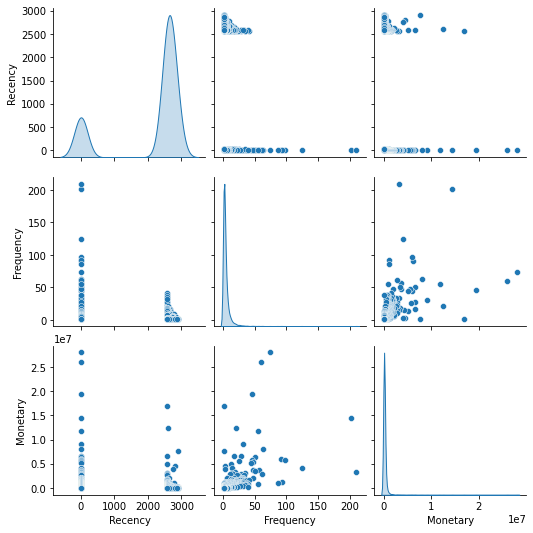

In [18]:
# 繪製RFM關聯圖:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

_ = sns.pairplot(rfm_data,diag_kind='kde')
print('All the features are highly right skewed.')

There is some positive correlation between Monetary and Frequency features.


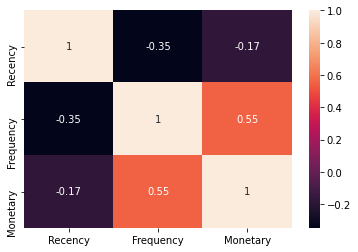

In [19]:
sns.heatmap(rfm_data.corr(),annot=True)
print('There is some positive correlation between Monetary and Frequency features.')

Recency  Frequency  Monetary
0 -1.990611   2.228021  4.302110
1 -1.967810   2.189298  4.252266
2 -1.964375   2.130843  4.061723
3  0.432594  -0.195479  3.966898
4 -1.995334   2.348232  3.861059

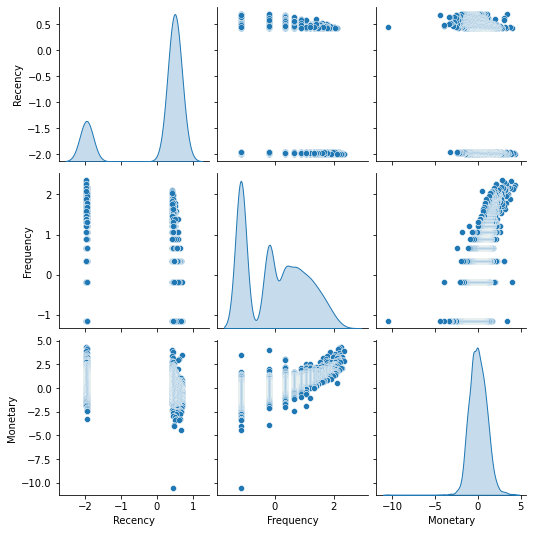

In [20]:
# 映射到高斯分布
from sklearn.preprocessing import PowerTransformer

features = rfm_data.columns
pt = PowerTransformer()
rfm_data = pd.DataFrame(pt.fit_transform(rfm_data))
rfm_data.columns = features
rfm_data.head()

sns.pairplot(rfm_data,diag_kind='kde')

There is high positive correlation between Frequency and Monetary features after applying Power transformation.


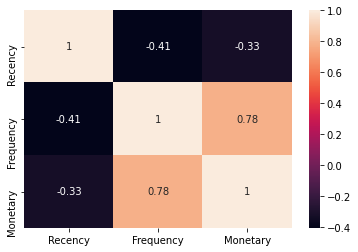

In [21]:
sns.heatmap(rfm_data.corr(),annot=True)
print('There is high positive correlation between Frequency and Monetary features after applying Power transformation.')

In [42]:
# 大多 Machine Learning 算法中，使用 StandardScaler 做特徵縮放，因為 MinMaxScaler 對異常值較敏感。
# 在PCA，cluster，Logistic Regression，SVM，NN 等算法裡, StandardScaler 往往是最好的選擇。
# MinMaxScaler 在不涉及距離度量、梯度、協方差以及數據需要被壓縮到特定區間時使用較多，比如數字圖像使用MinMaxScaler将數據壓縮在[0,1]之間。
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
rfm_scaled = sc.fit_transform(rfm_data)


from sklearn.decomposition import PCA # 看暗降為後
pca = PCA()
看按將為後pca_transformed_data = pca.fit_transform(rfm_scaled)

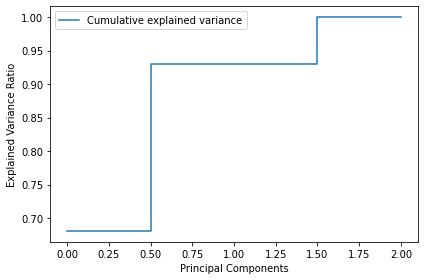

In [43]:
# 看降維度後, 可解釋性
var_exp = pca.explained_variance_ratio_
_ = plt.figure(figsize=(6,4))
# plt.bar(range(3), var_exp, alpha=0.5, align='center', label='Individual explained variance')
_ = plt.step(range(3), np.cumsum(var_exp), where='mid', label='Cumulative explained variance')
_ = plt.ylabel('Explained Variance Ratio')
_ = plt.xlabel('Principal Components')
_ = plt.legend(loc='best')
_ = plt.tight_layout()
_ = plt.show()

In [44]:
# 選兩個特徵： 
X = rfm_scaled.copy()
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(df_pca)
df_pca.head()

0         1
0 -4.999657 -0.424225
1 -4.933552 -0.415887
2 -4.775760 -0.331605
3 -2.152501 -1.854441
4 -4.804275 -0.280991

# K- means

In [45]:
X = df_pca.copy()


from sklearn.cluster import KMeans

cluster_range = range(1, 15)
cluster_intertia = []
cluster_sil_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_intertia.append( clusters.inertia_ )    # capture the intertia

# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame({ "num_clusters":cluster_range, "cluster_intertia": cluster_intertia} )
clusters_df[0:10]

KMeans(n_clusters=1, n_init=100, random_state=0)

KMeans(n_clusters=2, n_init=100, random_state=0)

KMeans(n_clusters=3, n_init=100, random_state=0)

KMeans(n_clusters=4, n_init=100, random_state=0)

KMeans(n_clusters=5, n_init=100, random_state=0)

KMeans(n_clusters=6, n_init=100, random_state=0)

KMeans(n_clusters=7, n_init=100, random_state=0)

KMeans(n_init=100, random_state=0)

KMeans(n_clusters=9, n_init=100, random_state=0)

KMeans(n_clusters=10, n_init=100, random_state=0)

KMeans(n_clusters=11, n_init=100, random_state=0)

KMeans(n_clusters=12, n_init=100, random_state=0)

KMeans(n_clusters=13, n_init=100, random_state=0)

KMeans(n_clusters=14, n_init=100, random_state=0)

num_clusters  cluster_intertia
0             1      12101.139540
1             2       6060.118564
2             3       3113.351040
3             4       2032.672370
4             5       1295.004237
5             6       1031.873912
6             7        802.785454
7             8        653.617109
8             9        535.155870
9            10        453.873853

<Figure size 864x432 with 0 Axes>

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Cluster Errors')

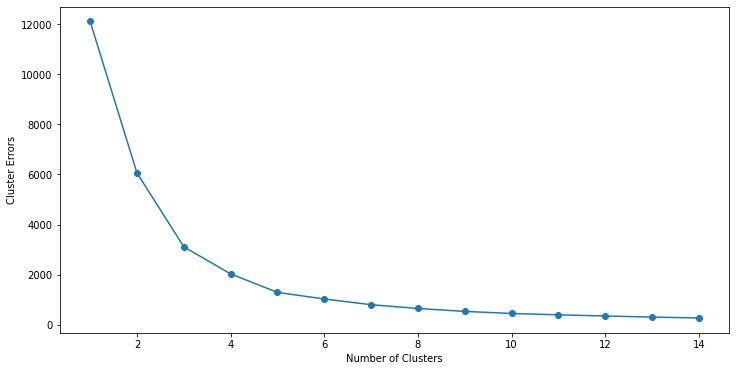

In [46]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot(clusters_df['num_clusters'], clusters_df['cluster_intertia'], marker = "o" )
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Errors')

In [47]:
for k in range(2,16):
    cluster = KMeans(n_clusters=k, random_state=0)
    labels = cluster.fit_predict(df_pca)
    
    sil_avg = silhouette_score(df_pca, labels)
    print('For',k,'clusters, average silhoutte score =',sil_avg)

For 2 clusters, average silhoutte score = 0.4784184835171883
For 3 clusters, average silhoutte score = 0.5564191074072902
For 4 clusters, average silhoutte score = 0.5886128049965329
For 5 clusters, average silhoutte score = 0.5702755799952228
For 6 clusters, average silhoutte score = 0.5609469274499014
For 7 clusters, average silhoutte score = 0.5243086840746045
For 8 clusters, average silhoutte score = 0.5065606475184998
For 9 clusters, average silhoutte score = 0.5091810555633152
For 10 clusters, average silhoutte score = 0.5038636472653084
For 11 clusters, average silhoutte score = 0.5013942304234041
For 12 clusters, average silhoutte score = 0.4995556986213079
For 13 clusters, average silhoutte score = 0.4894449634268501
For 14 clusters, average silhoutte score = 0.4877462684461491
For 15 clusters, average silhoutte score = 0.482160485966359


0         1  Cluster
0 -4.999657 -0.424225        2
1 -4.933552 -0.415887        2
2 -4.775760 -0.331605        2
3 -2.152501 -1.854441        0
4 -4.804275 -0.280991        2

1    1861
0    1593
2     541
3     344
Name: Cluster, dtype: int64

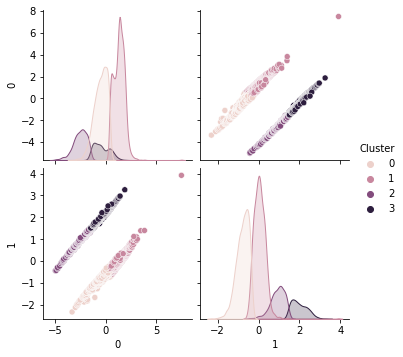

In [48]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(df_pca)
labels = kmeans.predict(df_pca)
centroids = kmeans.cluster_centers_


df_pca['Cluster'] = labels
df_pca.head()

df_pca['Cluster'].value_counts()

sns.pairplot(df_pca,diag_kind='kde',hue='Cluster')

In [49]:
# 客戶分群：
customers_grouped = pd.DataFrame(pt.inverse_transform(rfm_data),columns=rfm_data.columns,index=rfm_df.index)
customers_grouped['Cluster'] = df_pca['Cluster'].values
customers_grouped['RFMScore'] = rfm_segmentation['RFMScore'].values
customers_grouped.head()


Recency  Frequency    Monetary  Cluster RFMScore
CustomerID                                                  
14646.0         2.0       74.0  28020602.0        2      444
18102.0        14.0       60.0  25965730.0        2      444
17450.0        16.0       46.0  19439079.0        2      444
16446.0      2571.0        2.0  16847250.0        0      424
14911.0         0.0      201.0  14371117.0        2      444

In [50]:
# 客戶分群： Top_spenders and loyal_customers
top_spenders_and_loyal_customers = customers_grouped[(customers_grouped['RFMScore'] == '444') | (customers_grouped['RFMScore'] == '443') | (customers_grouped['RFMScore'] == '434')]
top_spenders_and_loyal_customers

Recency  Frequency    Monetary  Cluster RFMScore
CustomerID                                                  
14646.0         2.0       74.0  28020602.0        2      444
18102.0        14.0       60.0  25965730.0        2      444
17450.0        16.0       46.0  19439079.0        2      444
14911.0         0.0      201.0  14371117.0        2      444
14156.0        20.0       55.0  11721008.0        2      444
...             ...        ...         ...      ...      ...
16725.0         8.0        7.0     75827.0        2      443
14201.0         8.0        7.0     74744.0        2      443
17888.0         6.0        8.0     71600.0        2      443
15304.0        17.0        8.0     69440.0        2      443
15038.0        18.0        6.0     68574.0        2      443

[612 rows x 5 columns]

In [51]:
# 客戶分群： customers_churned
customers_churned = customers_grouped[(customers_grouped['RFMScore'] == '111') | (customers_grouped['RFMScore'] == '112') | (customers_grouped['RFMScore'] == '121')]
customers_churned

Recency  Frequency  Monetary  Cluster RFMScore
CustomerID                                                
14603.0      2845.0        1.0   66000.0        1      112
17046.0      2728.0        1.0   64202.0        1      112
14301.0      2688.0        1.0   64014.0        1      112
14000.0      2782.0        1.0   63566.0        1      112
14687.0      2677.0        1.0   62838.0        1      112
...             ...        ...       ...      ...      ...
16093.0      2677.0        1.0    1700.0        1      111
13307.0      2691.0        1.0    1500.0        1      111
17763.0      2834.0        1.0    1500.0        1      111
17956.0      2820.0        1.0    1275.0        1      111
16738.0      2868.0        1.0     375.0        1      111

[697 rows x 5 columns]

In [52]:
# 客戶分群： customers_at_risk_of_churning
customers_at_risk_of_churning = customers_grouped[(customers_grouped['RFMScore'] == '144') | (customers_grouped['RFMScore'] == '143') | (customers_grouped['RFMScore'] == '134') | (customers_grouped['RFMScore'] == '133') | (customers_grouped['RFMScore'] == '142') | (customers_grouped['RFMScore'] == '124')]
customers_at_risk_of_churning

Recency  Frequency   Monetary  Cluster RFMScore
CustomerID                                                 
15749.0      2806.0        3.0  4453430.0        0      134
15098.0      2753.0        3.0  3991650.0        0      134
12590.0      2782.0        2.0   986426.0        0      124
13802.0      2709.0        3.0   459942.0        0      134
18073.0      2685.0       12.0   385982.0        0      144
...             ...        ...        ...      ...      ...
16997.0      2859.0        3.0    70200.0        0      133
17472.0      2762.0        3.0    69754.0        0      133
17874.0      2756.0        6.0    68346.0        0      143
17994.0      2692.0        4.0    67489.0        0      133
13951.0      2747.0        3.0    67445.0        0      133

[107 rows x 5 columns]

In [53]:
# 客戶分群： new_customers or avg_spenders

new_customers_or_avg_spenders = customers_grouped[(customers_grouped['RFMScore'] == '422') | (customers_grouped['RFMScore'] == '411') | (customers_grouped['RFMScore'] == '412') | (customers_grouped['RFMScore'] == '421') | (customers_grouped['RFMScore'] == '413') | (customers_grouped['RFMScore'] == '431')]

new_customers_or_avg_spenders

Recency  Frequency  Monetary  Cluster RFMScore
CustomerID                                                
16270.0         2.0        1.0  114124.0        3      413
12713.0      2571.0        1.0   84855.0        1      413
13370.0        20.0        1.0   75487.0        3      413
12478.0      2574.0        1.0   68099.0        1      413
14150.0         8.0        2.0   65864.0        3      422
...             ...        ...       ...      ...      ...
14589.0        20.0        1.0    3975.0        3      411
12855.0        21.0        1.0    3810.0        3      411
17816.0        14.0        4.0    3656.0        3      431
14576.0        21.0        1.0    3540.0        3      411
15823.0        21.0        1.0    1500.0        3      411

[254 rows x 5 columns]

# Modelling
## Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve

In [55]:
y = df_pca['Cluster']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.3, random_state=42, stratify=y)

lr = LogisticRegression(max_iter=1000,random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [57]:
y_test_predicted = lr.predict(X_test)
y_train_predicted = lr.predict(X_train)

In [58]:
accuracy_train = accuracy_score(y_train, y_train_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)
print('Train Set Accuracy for Power Transformed Data:',round(accuracy_train*100,2),'%')
print('Test Set Accuracy for Power Transformed Data:',round(accuracy_test*100,2),'%')

kf= KFold(shuffle=True, n_splits=5, random_state=0)
score = cross_val_score(lr, df_pca, y, cv=kf, scoring='f1_weighted')
print('Bias Error:',1-np.mean(score))
print('Variance Error:',np.std(score,ddof=1))

cm = confusion_matrix(y_test, y_test_predicted)
print()
print('confusion_matrix:\n' ,cm)
print()
print(classification_report(y_test,y_test_predicted))

Train Set Accuracy for Power Transformed Data: 100.0 %
Test Set Accuracy for Power Transformed Data: 100.0 %
Bias Error: 0.0
Variance Error: 0.0

confusion_matrix:
 [[478   0   0   0]
 [  0 559   0   0]
 [  0   0 162   0]
 [  0   0   0 103]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       559
           2       1.00      1.00      1.00       162
           3       1.00      1.00      1.00       103

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



## Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
nb = GaussianNB()
score = cross_val_score(nb, df_pca, y, cv=kf, scoring='f1_weighted')
print('Bias Error:',1-np.mean(score))
print('Variance Error:',np.std(score,ddof=1))

nb.fit(X_train,y_train)

y_train_predicted = nb.predict(X_train)
y_test_predicted = nb.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print('Train Set Accuracy for Power Transformed Data:',round(accuracy_train*100,2),'%')
print('Test Set Accuracy for Power Transformed Data:',round(accuracy_test*100,2),'%')

print(confusion_matrix(y_test, y_test_predicted))

print(classification_report(y_test, y_test_predicted))

Bias Error: 0.0
Variance Error: 0.0


GaussianNB()

Train Set Accuracy for Power Transformed Data: 100.0 %
Test Set Accuracy for Power Transformed Data: 100.0 %
[[478   0   0   0]
 [  0 559   0   0]
 [  0   0 162   0]
 [  0   0   0 103]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       559
           2       1.00      1.00      1.00       162
           3       1.00      1.00      1.00       103

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

